<a href="https://colab.research.google.com/github/CetinkayaEge/CS210/blob/main/last_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests

In [ ]:
import time

In [ ]:
import pandas as pd

I have left the api key because it expires after 24h.

In [ ]:
api_key="RGAPI-5ad628dc-79a3-42a7-bad1-19ff793dd9a1"

The api uses puuuid for identifying players in game so we first access it using another call using game name.

In [ ]:
puuuid=requests.get("https://europe.api.riotgames.com/riot/account/v1/accounts/by-riot-id/Teyp/TR1"+"?api_key="+apikey)
puuuid=puuuid.json()
puuuid=puuuid["puuid"]

Extracting the match id's.

In [ ]:
def get_match_history(puuid, api_key, start, count,queue):
  url = "https://europe.api.riotgames.com/lol/match/v5/matches/by-puuid/" + puuid + "/ids?start=" + str(start) + "&count=" + str(count)+ "&queue=" + str(queue)  + "&api_key=" + api_key
  while True:
    response = requests.get(url)
    if(response.status_code==429):
      time.sleep(10)
    else:
      break
  return response.json()

In [ ]:
#matchids for ranked solo/duo gametype
matchids=get_match_history(puuuid,api_key,0,100,420)
#matchids for ranked flex gametype
matchids2=get_match_history(puuuid,api_key,0,100,440)

I have put 10 seconds sleep if the request returns 429 which means the request limit has been exceeded because the api has a request limit for every 2 minutes.

In [ ]:
def get_match_data(match_id,api_key):
  url="https://europe.api.riotgames.com/lol/match/v5/matches/"+str(match_id)+"?api_key="+str(api_key)
  while True:
    response = requests.get(url)
    if(response.status_code==429):
      time.sleep(10)
    else:
      break
  return response.json()

In [ ]:
detailed_match_history1=[]
for match_id in matchids:
  match_data=get_match_data(match_id,api_key)
  detailed_match_history1.append(match_data)

detailed_match_history2=[]
for match_id in matchids2:
  match_data=get_match_data(match_id,api_key)
  detailed_match_history2.append(match_data)


In [ ]:
detailed_match_history1[0]

{'metadata': {'dataVersion': '2',
  'matchId': 'TR1_1578770516',
  'participants': ['jgEbXR20PXPIGW5pya93HGFcVXU6vGjjY1tPP9y2upjpyK4IjG7Co-ASMccnNSRlbXUncfsdc0fiMw',
   '8bxOwI8CP0l8TSv7ACeO_XxRjwaOWnZZOL8iZJ0_IQ318ErzD9pf-71Qz953znej1PYKDps14sbtlQ',
   'etXf7XNQuJmepxed400ZNCfxf8GHSa4YoPDA7ptV9_T3eDGlUpBZ2IXRTNPJLdBAnwhTLesIffjGUw',
   'l-n38XHxeYmdbENbrNtZA9xjvVezc3tpnzSv3-gVSm3O_4agjybGHTTxHeTES-BN__rXLXeYtBHnWQ',
   'Uu8C1PUalAtVnJlyL90Az-dA3v8bpYzt9c9TtDevFpR72eVoNCcHCzhLs07qGcueMjOmoMKaAeTEMg',
   'HUB6M31yydZfIYPgrIdtx-jOW4y33JeQAwCd4wmdhNDWC-1O9Gi3_8r35ez9n8aBiNlmUTq7fwHzLQ',
   '0Zqm5LgypTyRCtiOu70hU6nzQLmXVBvuSNGobjJi-7CIxu0Y_rt-raNBdFJOZswvhqkqaeMH-c5cIw',
   'cEJgH4GWoUESU7BXVx7AJ0Sm7c_9K1UU30nwfz9Y_K0oSlEvAzUb-4mT0hrCoHc368SLUXw5Fwg4Nw',
   'HSE8FQaL4QrtJkuzqV7yETgh7uhCZI39WSFAx_oFMlYJb7be6C87HRR1dlDNLGuR-aU56uKMyMfuFw',
   'ynxo6abT78gjs51y_19bE0pwdBQ19943vpEZbwsfr_GXRa-NM8FwRhOw58kMQK-H4jqPOsOrlSHBvQ']},
 'info': {'endOfGameResult': 'GameComplete',
  'gameCreation': 1735

extract the match data for a single player because the request gather data for each player in the game.

---


variables ending with 1 is for solo/duo game type

---


variales ending with 2 is for flex game type

In [ ]:
def extract_player_data(detailed_match_history, target_puuid):
  player_data = []
  for match_data in detailed_match_history:
    data=[]
    data.append(match_data['info']['gameDuration'])
    for participant in match_data["info"]["participants"]:
      if participant["puuid"] == target_puuid:
        data.append(participant["kills"])
        data.append(participant["deaths"])
        data.append(participant["assists"])
        data.append(participant["championName"])
        data.append(participant["win"])
        player_data.append(data)
        break
  return player_data

In [ ]:
player_data1 = extract_player_data(detailed_match_history1, puuuid)
player_data2 = extract_player_data(detailed_match_history2, puuuid)

transfer the data in to pandas data frame in order to analyze more easily.

In [ ]:
columns = ["gameDuration", "kills", "deaths", "assists", "championName", "win"]
df = pd.DataFrame(player_data1, columns=columns)
df2= pd.DataFrame(player_data2, columns=columns)
df["win_numeric"] = df["win"].astype(int)
df2["win_numeric"] = df2["win"].astype(int)

turn gameduration from seconds to minutes.

In [ ]:
df["gameDuration"] = df["gameDuration"] / 60
df2["gameDuration"] = df2["gameDuration"] / 60

add a column called KDA for better representation.Replaces 0's with 1 to prevent division by 0.

In [ ]:
df["KDA"] = (df["kills"] + df["assists"]) / df["deaths"].replace(0, 1)
df2["KDA"] = (df2["kills"] + df2["assists"]) / df2["deaths"].replace(0, 1)

In [ ]:
print(df.describe())
print(df2.describe())

       gameDuration       kills      deaths     assists  win_numeric  \
count    100.000000  100.000000  100.000000  100.000000    100.00000   
mean      31.002000    5.020000    6.910000   10.370000      0.43000   
std        7.969147    3.829656    3.312343    7.874848      0.49757   
min        1.750000    0.000000    0.000000    0.000000      0.00000   
25%       27.387500    2.000000    5.000000    4.750000      0.00000   
50%       30.766667    4.000000    7.000000    9.000000      0.00000   
75%       35.908333    7.000000    9.000000   15.000000      1.00000   
max       46.466667   19.000000   19.000000   36.000000      1.00000   

              KDA  
count  100.000000  
mean     2.901475  
std      2.932408  
min      0.000000  
25%      1.200000  
50%      1.866071  
75%      3.562500  
max     15.000000  
       gameDuration       kills      deaths     assists  win_numeric  \
count    100.000000  100.000000  100.000000  100.000000   100.000000   
mean      29.454167    4.91

In [ ]:
print(df["championName"].value_counts())
print(df2["championName"].value_counts())

championName
Chogath        6
Thresh         5
Zac            5
Sejuani        4
Sion           4
Skarner        3
Shen           3
Trundle        3
Ekko           3
Ahri           3
TahmKench      3
Gragas         2
Rammus         2
Jax            2
Yorick         2
Lissandra      2
Lux            2
Milio          2
Urgot          2
Fizz           2
Soraka         2
Nasus          2
Talon          2
JarvanIV       2
Vayne          1
Gwen           1
Ezreal         1
Gnar           1
Quinn          1
Volibear       1
Malphite       1
Pantheon       1
Sivir          1
Fiora          1
DrMundo        1
Renekton       1
Amumu          1
AurelionSol    1
Ornn           1
Braum          1
Twitch         1
Seraphine      1
Morgana        1
Diana          1
Jayce          1
Belveth        1
Briar          1
Elise          1
Vi             1
Karma          1
Lulu           1
Syndra         1
Malzahar       1
Nautilus       1
Jhin           1
Garen          1
Name: count, dtype: int64
championN

In [ ]:
win_rate = df["win"].mean()
print("Win Rate:", win_rate)

Win Rate: 0.43


In [ ]:
win_rate2 = df2["win"].mean()
print("Win Rate:", win_rate2)

Win Rate: 0.49


using seaborn and matplot to visualise the data

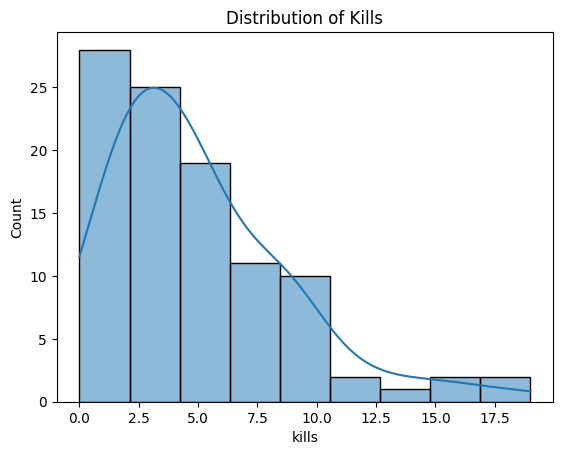

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df["kills"], kde=True)
plt.title("Distribution of Kills")
plt.show()

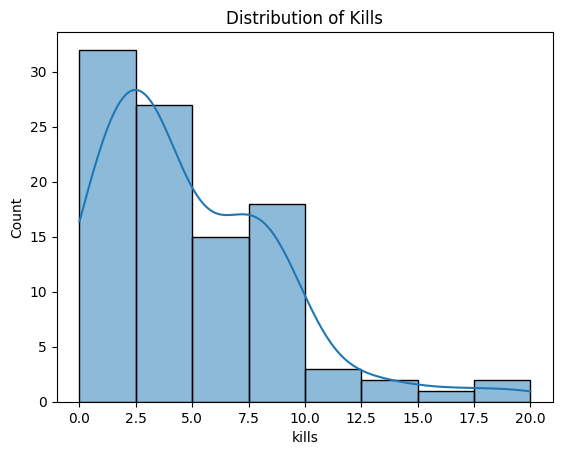

In [ ]:
sns.histplot(df2["kills"], kde=True)
plt.title("Distribution of Kills")
plt.show()

champion average win rate

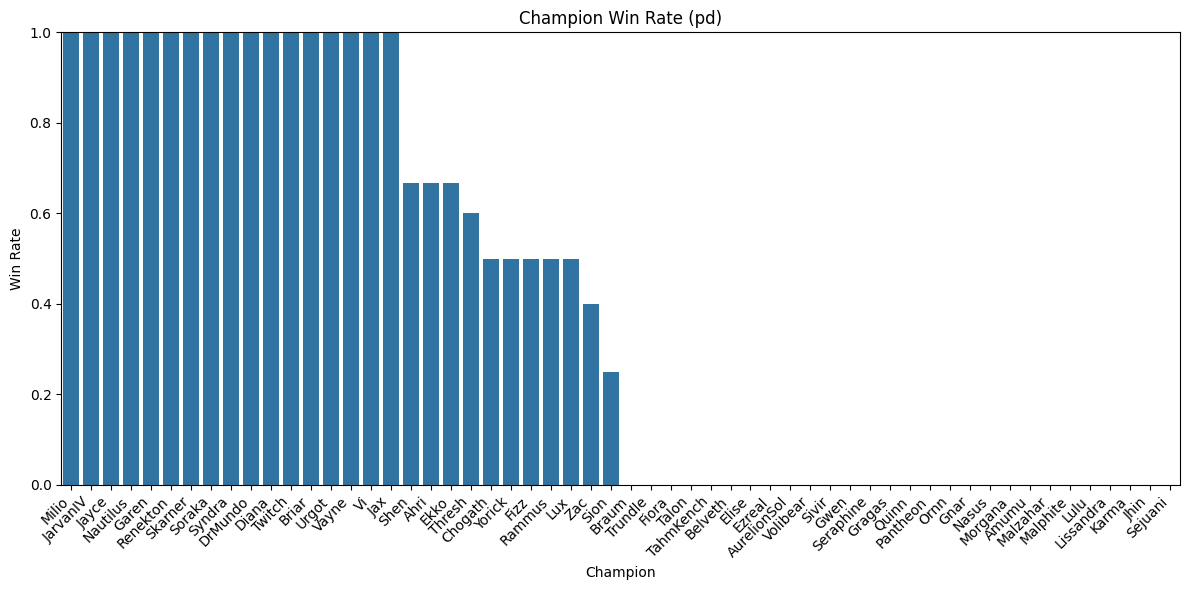

In [ ]:
champion_win_rates_pd=df.groupby("championName")["win"].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=champion_win_rates_pd.index, y=champion_win_rates_pd.values)
plt.title("Champion Win Rate (pd)")
plt.xlabel("Champion")
plt.ylabel("Win Rate")

plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


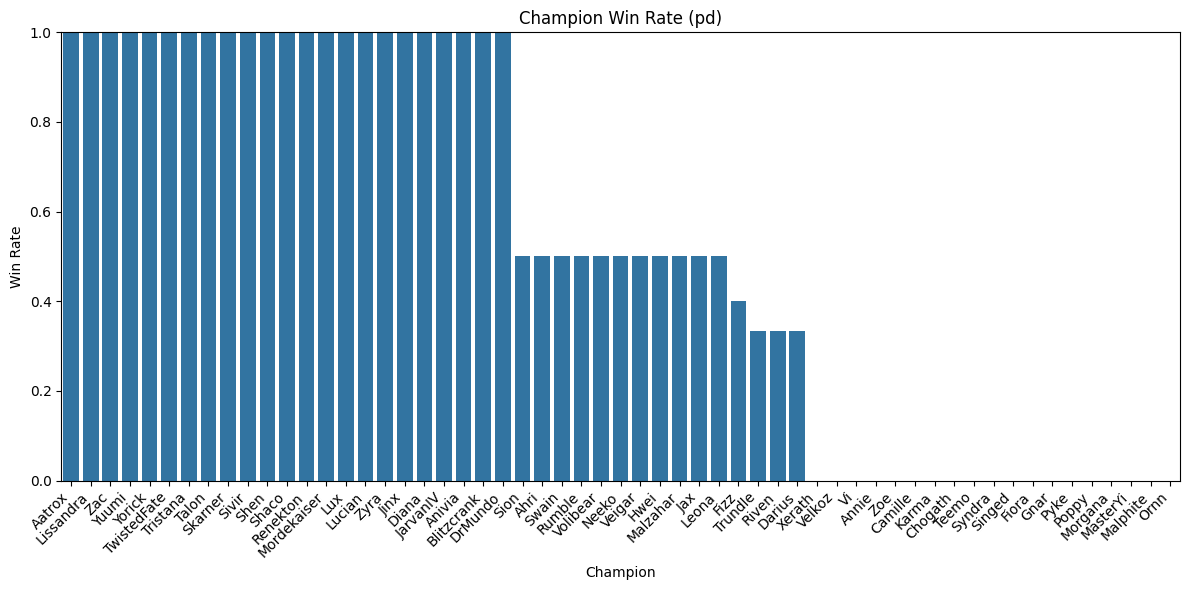

In [ ]:
champion_win_rates_pd2=df2.groupby("championName")["win"].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=champion_win_rates_pd2.index, y=champion_win_rates_pd2.values)
plt.title("Champion Win Rate (pd)")
plt.xlabel("Champion")
plt.ylabel("Win Rate")

plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


correlation between variables

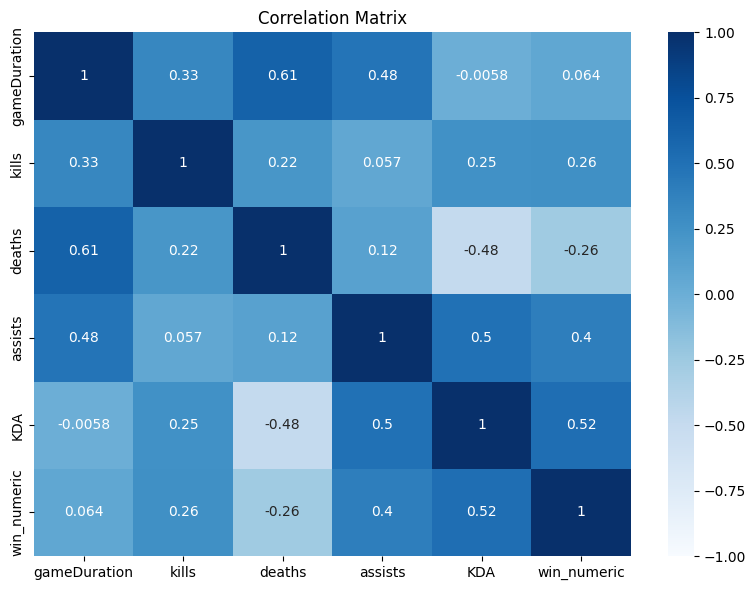

In [ ]:
numeric_columns = ["gameDuration", "kills", "deaths", "assists", "KDA", "win_numeric"]


corr_matrix1 = df[numeric_columns].corr()


plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix1, annot=True, cmap="Blues", vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

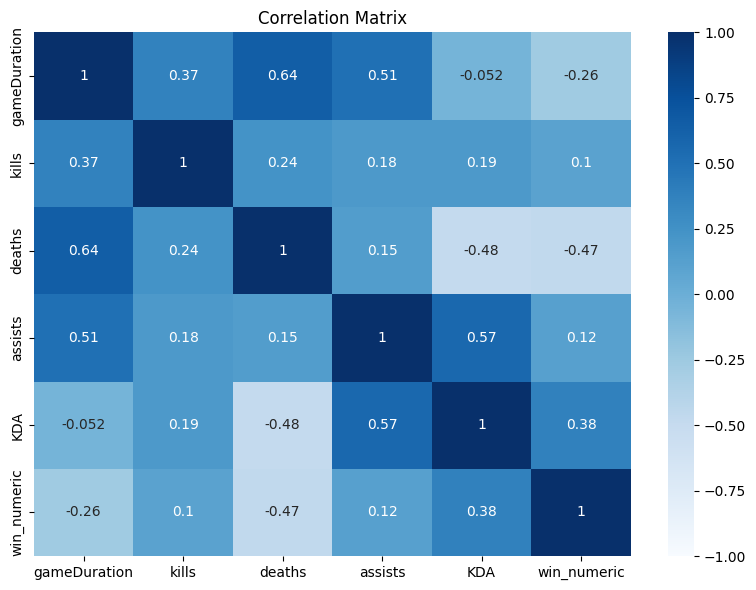

In [ ]:
numeric_columns = ["gameDuration", "kills", "deaths", "assists", "KDA", "win_numeric"]


corr_matrix2 = df2[numeric_columns].corr()


plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix2, annot=True, cmap="Blues", vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

H0 kda doesn't effect win rate
H1 Kda effects win rate

In [198]:
df_win  = df[df['win_numeric'] == 1]
df_loss = df[df['win_numeric'] == 0]

In [201]:
from scipy import stats
kda_wins  = df_win['KDA'].dropna()
kda_losses = df_loss['KDA'].dropna()

stat, p_value = stats.ttest_ind(kda_wins, kda_losses, equal_var=False)

print("T-statistic:", stat)
print("p-value:", p_value)
alpha = 0.05

T-statistic: 5.422833996536089
p-value: 1.5222390819738825e-06
